## Find maximum likelihood with Scipy and compare to Iminuit


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from scipy.optimize import minimize
# our modules
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data
test_sim_num=15
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,
                                basedir=basedir,
                                skewers_label=skewers_label,
                                data_cov_factor=0.1)

Setup archive of P1D measurements from simulations to train the emulator

In [3]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup likelihood and free parameters

In [5]:
# Likelihood parameters (option to add also redshift evolution, might be slower)
add_z_evol=True
if add_z_evol:
    like_params=["Delta2_star","n_star","ln_tau_0","ln_tau_1",
            "ln_sigT_kms_0","ln_sigT_kms_1","ln_gamma_0","ln_gamma_1",
            "ln_kF_0","ln_kF_1"]
    like_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2]]
else:
    like_params=["Delta2_star","n_star","ln_tau_0","ln_sigT_kms_0",
            "ln_gamma_0","ln_kF_0"]
    like_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]

In [6]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_parameters=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=-1,
                            emu_cov_factor=1,
                            use_sim_cosmo=False)

In [7]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
Delta2_star = 0.355
n_star = -2.301
ln_tau_0 = 0.0
ln_tau_1 = 0.0
ln_sigT_kms_0 = 0.0
ln_sigT_kms_1 = 0.0
ln_gamma_0 = 0.0
ln_gamma_1 = 0.0
ln_kF_0 = 0.0
ln_kF_1 = 0.0
starting chi2 1675.1679520121106


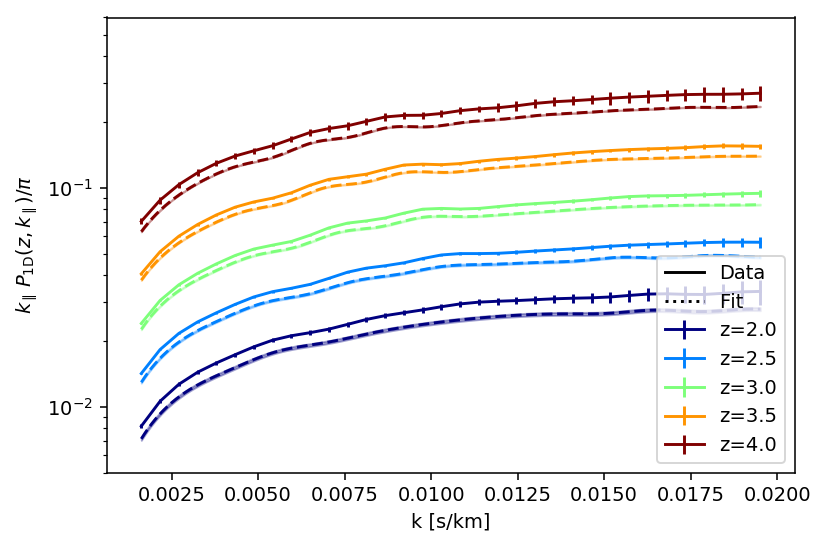

In [8]:
like.plot_p1d(plot_every_iz=2)

# Run minimiser

In [9]:
results=like.maximise_posterior(initial_values=theta,tol=1e-5)
print('max prob =',results.fun)
min_chi2=like.get_chi2(results.x)
print('minimum chi2',min_chi2)
print('minimizer info',results)
for par in like.parameters_from_sampling_point(results.x):
    print(par.info_str())

max prob = -484.3085293219261
minimum chi2 27.80845532368099
minimizer info  final_simplex: (array([[0.26597652, 0.62880486, 0.72165302, 0.46493485, 0.28043647,
        0.57466061, 0.19838442, 0.12840159, 0.42027825, 0.53845881],
       [0.26597632, 0.62880411, 0.72165324, 0.4649353 , 0.28043816,
        0.57466033, 0.19838541, 0.12840203, 0.42027867, 0.53845966],
       [0.26597647, 0.62880492, 0.72165315, 0.46493427, 0.28043009,
        0.57466084, 0.1983841 , 0.12839797, 0.42027797, 0.53845739],
       [0.26597569, 0.62880432, 0.72165345, 0.46493554, 0.28043591,
        0.57466049, 0.19838395, 0.1284074 , 0.42027788, 0.53845656],
       [0.2659769 , 0.62880421, 0.7216532 , 0.46493419, 0.28043117,
        0.57466004, 0.19838457, 0.12839984, 0.42027936, 0.53845532],
       [0.26597613, 0.62880469, 0.72165407, 0.46493317, 0.28042778,
        0.57465904, 0.19838499, 0.12839785, 0.42027891, 0.53845516],
       [0.26597718, 0.62880516, 0.72165289, 0.46493347, 0.28043038,
        0.5746612

### Compare to truth

In [10]:
true_linP_params=like.get_simulation_linP_params(test_sim_num)
print('truth',true_linP_params)

truth {'f_star': 0.9813930720506915, 'g_star': 0.9677508863420937, 'linP_kms': poly1d([-0.10826455, -2.2984383 , 15.92192086]), 'Delta2_star': 0.30352897796173783, 'n_star': -2.2984383048833426, 'alpha_star': -0.21652910656157118}


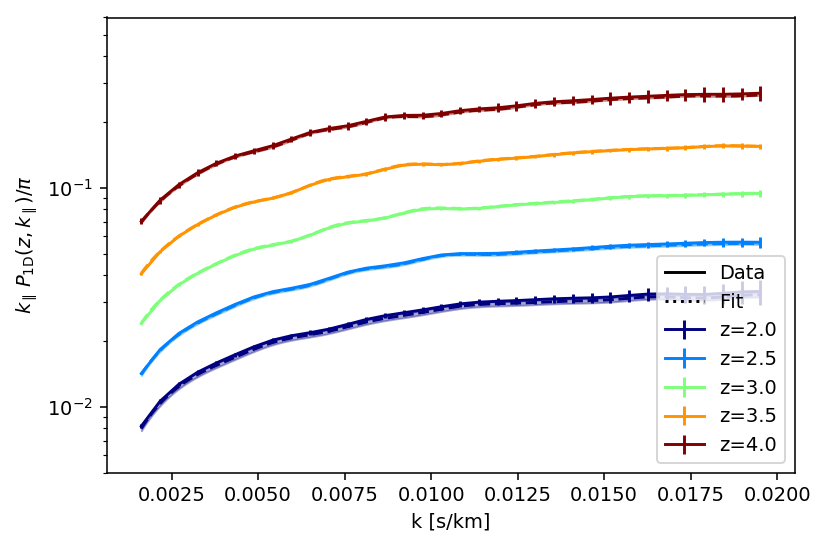

In [11]:
like.plot_p1d(plot_every_iz=2,values=results.x)

# Now try iminuit

In [12]:
from iminuit import Minuit

In [13]:
m = Minuit.from_array_func(like.get_chi2,theta,error=0.1,errordef=1)
#m = Minuit.from_array_func(like.minus_log_prob,theta,error=0.01,errordef=0.5) FOR SOME REASON IT CRASHES

In [14]:
# run optimiser
m.migrad()

------------------------------------------------------------------
| FCN = 25.79                   |     Ncalls=769 (769 total)     |
| EDM = 4.35E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.268   |   0.025   |            |            |         |         |       |
| 1 | x1   |   0.634   |   0.025   |            |            |         |         |       |
| 2 | x2   |   0.714   |   0.019   |            |            |         |         |       |
| 3 | x3   |   0.49    |   0.08    |            |            |         |         |       |
| 4 | x4   |   0.25    |   0.28    |            |            |         |         |       |
| 5 | x5   |   0.586   |   0.031   |            |            |         |         |       |
| 6 | x6   |   0.178   |   0.024   |            |            |         |         |       |
| 7 | x7   |   0.13    |   0.20    |            |            |         |         |       |
| 8 | x8   |   0.40    |   0.03    |            |            |         |         |       |
| 9 | x9   |   0.63    |   0.12    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [15]:
min_chi2=like.get_chi2(m.values)
print('minimum chi2',min_chi2)
print(m.get_fmin())
for par in like.parameters_from_sampling_point(m.values):
    print(par.info_str())

minimum chi2 25.793464700009412
------------------------------------------------------------------
| FCN = 25.79                   |     Ncalls=769 (769 total)     |
| EDM = 4.35E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
Delta2_star = 0.3015677987265207
n_star = -2.2873347449022923
ln_tau_0 = 0.08551398313813474
ln_tau_1 = -0.004237899352671243
ln_sigT_kms_0 = -0.09956569333108634
l

In [16]:
i=0
errors=np.zeros(len(m.values))
for par in like.parameters_from_sampling_point(m.values):
    cube_value=m.values[i]
    cube_error=m.errors[i]
    value=par.value_from_cube(cube_value)
    errors[i]=cube_error*(par.max_value-par.min_value)
    if par.name in true_linP_params:
        print('cosmo {} = {:g} +/- {:g} (truth = {:g})'.format(par.name,value,errors[i],true_linP_params[par.name]))
    else:    
        print('IGM {} = {:g} +/- {:g}'.format(par.name,value,errors[i]))
    #print(i,cube_value,cube_error,value,errors[i],par.info_str())    
    i+=1

cosmo Delta2_star = 0.301568 +/- 0.00576116 (truth = 0.303529)
cosmo n_star = -2.28733 +/- 0.0025907 (truth = -2.29844)
IGM ln_tau_0 = 0.085514 +/- 0.00748156
IGM ln_tau_1 = -0.0042379 +/- 0.0317192
IGM ln_sigT_kms_0 = -0.0995657 +/- 0.112573
IGM ln_sigT_kms_1 = 0.0344426 +/- 0.0125613
IGM ln_gamma_0 = -0.128745 +/- 0.00958822
IGM ln_gamma_1 = -0.148697 +/- 0.0784983
IGM ln_kF_0 = -0.0391078 +/- 0.0138907
IGM ln_kF_1 = 0.053951 +/- 0.047787
